# Оценка недвижимости

# Содержание

- [Описание проекта](#1)
- [Общая информация о данных](#2)
- [Предобработка данных](#3)
- [Анализ стоимости квартир](#4)
- [Заключение](#5)

# Описание проекта <a id='1'></a>

**Цель: Установить параметры определяющие рыночную стоимость объектов недвижимости.**

Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.


# Общая информация о данных <a id='2'></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('real_estate_data.csv', sep='\t')
df.info()
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


# Предобработка данных <a id='3'></a>

Удалим дубликаты (если они есть).

По результатам анализа пропущенных значений и типов данных:
- Заменим не указанное число балконов (скорее всего, их нет) на 0. 
- Заменим вещественный тип данных в столбце: balcony на целочисленный.
- Заменим тип данных в first_day_exposition на datetime.

В данных присутствует достаточно большое количество пропусков, например высототы потолка, удалённости от центра и др. Однако учитывая многообразие параметров, характеризующих квартиру (и в той или иний мере влияющих на цену квартиры), и с целью недопущения внесения искажений в результаты анализа  влияния исследуемых параметров на цену квартиры, заменять отсутствующие значения средними или медианными значениями не будем.

In [2]:
df = df.drop_duplicates().reset_index(drop=True)


In [3]:
df['balcony'] = df['balcony'].fillna(value = 0)
df['balcony'] = df['balcony'].astype('int')
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S' 
)

Добавим в таблицу:
- цену квадратного метра;
- день недели, месяц и год публикации объявления;
- этаж квартиры: первый, последний, другой;
- соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [4]:
df['price_m'] = df['last_price'] / df['total_area']
df['share_area_living'] = df['living_area'] / df['total_area']
df['share_area_kitchen'] = df['kitchen_area'] / df['total_area']

df['year'] = df['first_day_exposition'].dt.year
df['month'] = df['first_day_exposition'].dt.month
df['weekday'] = df['first_day_exposition'].dt.weekday


In [5]:
def floor_group(df):
    floors_total = df['floors_total']
    floor = df['floor']
    if floor == 1.0: 
        return 'первый'
    if floor == floors_total: 
        return 'последний'
    return 'другой'
 

In [6]:
df['floor_group'] = df.apply(floor_group, axis = 1)


**Выводы**

В результате анализа данных о платёжеспособности клиентов:

- найдена зависимость между количеством детей и возвратом кредита в срок.
- выделены категории граждан по семейному положению имеющие большую долю задержек платежей по кредитам.
- найдена зависимость между уровнем дохода и возвратом кредита в срок.
- определены цели кредита по которым с большей и меньшей долей задержек платежей по кредитам.


# Анализ стоимости квартир <a id='4'></a>

**Гистограмма общей площади.**

<AxesSubplot:>

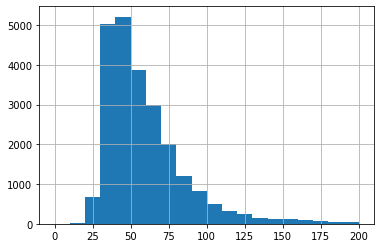

In [7]:
df['total_area'].hist(bins=20, range=(0, 200))

Для наглядности, отдельно, простроим "хвосты" гистограмм.

<AxesSubplot:>

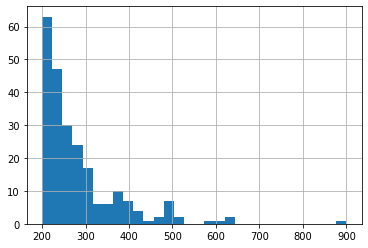

In [8]:
df['total_area'].hist(bins=30, range=(200, 900))

Из гистограммы общей площади видно, что наибольшее количество предложений приходится на квартиры с площадью от 30 до 60 кв.м, единичны предложения квартир с площадью более 400 кв.м.
Форма гитограммы близка к распределению Пуассона. Явно выделяется квартира площадью около 900 кв.м.

**Гистограмма цены.**

<AxesSubplot:>

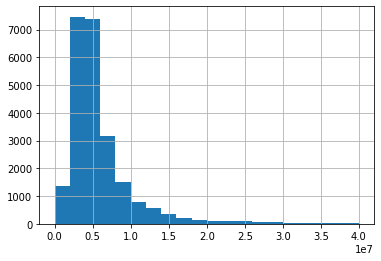

In [9]:
df['last_price'].hist(bins=20, range=(0, 40000000))

<AxesSubplot:>

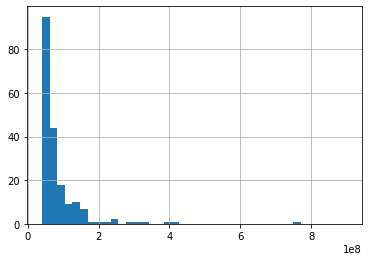

In [10]:
df['last_price'].hist(bins=40, range=(40000000, 900000000))

Из гистограммы цены видно, что наибольшее количество предложений приходится на квартиры с ценой от 2 до 6 млн.р., единичны предложения квартир ценой выше 18 млн.р. Форма гитограммы близка к распределению Пуассона. Явно выделяется квартира с ценой около 75 млн.р.

**Гистограмма числа комнат.**

<AxesSubplot:>

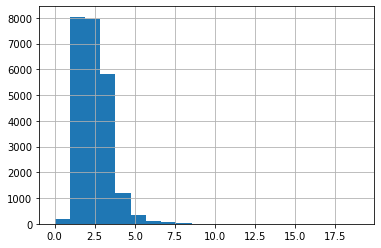

In [11]:
df['rooms'].hist(bins=20)

<AxesSubplot:>

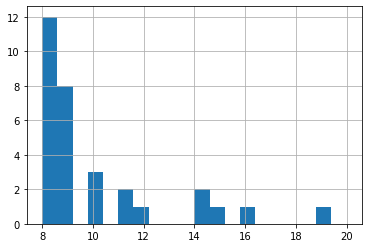

In [12]:
df['rooms'].hist(bins=20, range=(8, 20))

Из гистограмм видно, что на продажу выставлены преимущественно 2-3 комнатные кваритры. Единичны предложения квартир с числом комнат больше 10. Форма гитограммы близка к распределению Пуассона. Явно выделяеются квартиры с числом комнат больше 12.

**Гистограмма высоты потолков.**

<AxesSubplot:>

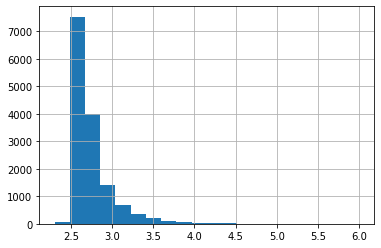

In [13]:
df['ceiling_height'].hist(bins=20, range=(2.3, 6))

<AxesSubplot:>

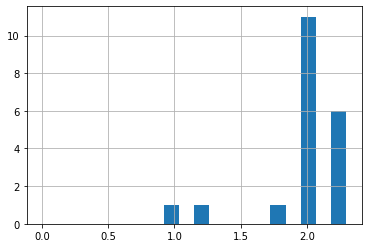

In [14]:
df['ceiling_height'].hist(bins=20, range=(0, 2.3))

<AxesSubplot:>

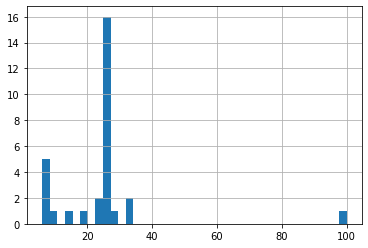

In [15]:
df['ceiling_height'].hist(bins=40, range=(6, 100))

Из гистограмм видно, что наибольшее количество предложений приходится на квартиры с высотой потолков от 2.5 до 2.8 м. Непонятна высота потолков больше 10-15 м (высота 4-5 этажного дома!), при этом много квартир (16 шт.) с высотой 2.6-2.8 м (можно предположить, что при вводе данных не поставили запятую). Форма гитограммы близка к распределению Пуассона. Явно выделяется квартира высотой 100 м, а также непонятны квартиры с высотой менее 2 м.

**Анализ времени продажи.**

<AxesSubplot:>

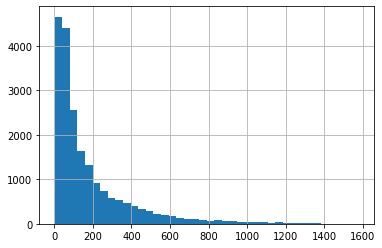

In [16]:
df['days_exposition'].hist(bins=40)

<AxesSubplot:>

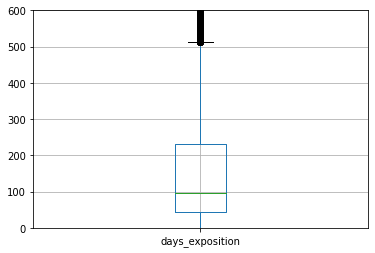

In [17]:
plt.ylim(0, 600)
df.boxplot(column=['days_exposition'])

In [18]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Применённые инструменты анализа данных показывают, среднее время продажи составляет 181 день, медианное значение времени продажи почти в два раза меньше и составляет 95 дней (т.е. половина продаж совершается в теченние 3 месяцев). Быстрыми можно считать продажи не превышающие 45 дней, длительными - более 232 дней.

Детально рассмотрим выделяющиеся из общей совокупности квартиры.

In [19]:
display(df[df['ceiling_height'] > 6].head(30))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
355,17,3600000.0,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,NaN,259.0,65217.391304,0.579710,NaN,2018,7,3,другой
3148,14,2900000.0,75.0,2018-11-12,3,32.0,3.0,53.0,2,NaN,...,NaN,NaN,NaN,38666.666667,0.706667,0.106667,2018,11,0,другой
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,NaN,NaN,125.0,46666.666667,0.510000,0.243333,2018,3,4,другой
4643,0,4300000.0,45.0,2018-02-01,2,25.0,9.0,30.0,2,NaN,...,1.0,331.0,181.0,95555.555556,0.666667,0.155556,2018,2,3,другой
4876,7,3000000.0,25.0,2017-09-27,0,27.0,25.0,17.0,17,NaN,...,NaN,NaN,28.0,120000.000000,0.680000,NaN,2017,9,2,другой
5076,0,3850000.0,30.5,2018-10-03,1,24.0,5.0,19.5,1,True,...,1.0,578.0,7.0,126229.508197,0.639344,0.180328,2018,10,2,первый
5246,0,2500000.0,54.0,2017-10-13,2,27.0,5.0,30.0,3,NaN,...,NaN,NaN,540.0,46296.296296,0.555556,0.166667,2017,10,4,другой
5669,4,4400000.0,50.0,2017-08-08,2,26.0,9.0,21.3,3,NaN,...,0.0,NaN,267.0,88000.000000,0.426000,0.140000,2017,8,1,другой
5807,17,8150000.0,80.0,2019-01-09,2,27.0,36.0,41.0,13,NaN,...,3.0,80.0,38.0,101875.000000,0.512500,0.150000,2019,1,2,другой
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,1.0,613.0,14.0,125555.555556,0.428889,0.184444,2018,8,2,другой


Явно выделяющихся по цене, площади и др. параметрам квартир нет. Заменим (вероятно результат опечаток) значения в диапазоне от 22 до 32 м.

In [20]:
df.loc[df['ceiling_height'] == 25, 'ceiling_height'] = 2.5
df.loc[df['ceiling_height'] == 32, 'ceiling_height'] = 3.2
df.loc[df['ceiling_height'] == 27, 'ceiling_height'] = 2.7
df.loc[df['ceiling_height'] == 26, 'ceiling_height'] = 2.6
df.loc[df['ceiling_height'] == 24, 'ceiling_height'] = 2.4
df.loc[df['ceiling_height'] == 22.6, 'ceiling_height'] = 2.26
df.loc[df['ceiling_height'] == 27.5, 'ceiling_height'] = 2.75




In [21]:
display(df[df['ceiling_height'] < 2].head(30))
display(df[df['ceiling_height'] > 6].head(30))
display(df[df['total_area'] > 500].head(30))
display(df[df['last_price'] > 180000000].head(30))
display(df[df['rooms'] > 12].head(30))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2.0,27.5,1,NaN,...,NaN,NaN,248.0,35046.728972,0.642523,0.121495,2017,8,0,первый
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,NaN,...,3.0,80.0,71.0,102500.000000,0.435000,0.208500,2017,10,1,другой
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12.0,32.4,7,NaN,...,2.0,289.0,13.0,109090.909091,0.589091,0.181818,2018,10,2,другой


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,NaN,NaN,125.0,46666.666667,0.510000,0.243333,2018,3,4,другой
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,1.0,613.0,14.0,125555.555556,0.428889,0.184444,2018,8,2,другой
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14.0,32.4,5,NaN,...,0.0,NaN,315.0,99290.780142,0.574468,0.161348,2018,5,4,другой
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,0.0,NaN,474.0,83582.089552,0.611940,0.119403,2016,11,4,первый
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,...,0.0,NaN,469.0,99074.074074,0.537037,NaN,2015,6,1,другой
17496,15,6700000.0,92.9,2019-02-19,3,20.0,17.0,53.2,14,NaN,...,0.0,NaN,NaN,72120.559742,0.572659,0.129171,2019,2,1,другой
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16.0,15.5,15,NaN,...,2.0,450.0,136.0,117777.777778,0.344444,NaN,2017,9,5,другой
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5.0,14.0,5,True,...,3.0,30.0,19.0,600000.000000,0.560000,0.440000,2018,7,2,последний


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5.0,NaN,5,NaN,...,2.0,210.0,NaN,221870.047544,NaN,0.095087,2019,3,5,последний
4237,1,50000000.0,517.0,2017-10-14,7,NaN,4.0,332.0,3,NaN,...,2.0,540.0,NaN,96711.798839,0.642166,0.042553,2017,10,5,другой
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,NaN,...,0.0,NaN,14.0,110169.491525,0.693220,0.169492,2019,2,3,другой
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.5,7,True,...,0.0,NaN,1078.0,165680.473373,0.594675,0.089744,2015,12,3,последний
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.3,4,NaN,...,2.0,210.0,NaN,221799.746515,0.510615,0.030894,2019,4,1,последний
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.0,5,NaN,...,2.0,198.0,111.0,485436.893204,0.417476,0.113269,2017,12,0,другой
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,NaN,...,2.0,318.0,106.0,466666.666667,0.455222,0.124444,2017,12,2,последний


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7.0,95.0,5,NaN,...,3.0,285.0,233.0,1.736842e+06,0.500000,0.210526,2018,4,2,другой
5893,3,230000000.0,500.0,2017-05-31,6,NaN,7.0,NaN,7,NaN,...,2.0,198.0,50.0,4.600000e+05,NaN,0.080000,2017,5,2,последний
8900,13,190870000.0,268.0,2016-03-25,3,NaN,8.0,132.0,7,NaN,...,2.0,198.0,901.0,7.122015e+05,0.492537,0.149254,2016,3,4,другой
12971,19,763000000.0,400.0,2017-09-30,7,NaN,10.0,250.0,10,NaN,...,3.0,756.0,33.0,1.907500e+06,0.625000,NaN,2017,9,5,последний
13749,7,240000000.0,410.0,2017-04-01,6,3.40,7.0,218.0,7,NaN,...,2.0,198.0,199.0,5.853659e+05,0.531707,0.097561,2017,4,5,последний
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9.0,204.0,9,False,...,1.0,478.0,393.0,1.000748e+06,0.508728,0.059850,2016,2,5,последний
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7.0,258.0,5,NaN,...,2.0,198.0,111.0,4.854369e+05,0.417476,0.113269,2017,12,0,другой
16461,17,245000000.0,285.7,2017-04-10,6,3.35,7.0,182.8,4,NaN,...,3.0,140.0,249.0,8.575429e+05,0.639832,0.104305,2017,4,0,другой
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,NaN,...,2.0,318.0,106.0,4.666667e+05,0.455222,0.124444,2017,12,2,последний
22831,18,289238400.0,187.5,2019-03-19,2,3.37,6.0,63.7,6,NaN,...,3.0,188.0,NaN,1.542605e+06,0.339733,0.161067,2019,3,1,последний


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group
866,5,25000000.0,363.0,2017-12-23,14,3.16,5.0,222.0,4,NaN,...,2.0,435.0,418.0,68870.523416,0.611570,0.045730,2017,12,5,другой
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,NaN,...,0.0,NaN,14.0,110169.491525,0.693220,0.169492,2019,2,3,другой
14498,6,32250000.0,374.6,2018-06-09,19,NaN,5.0,264.5,2,NaN,...,2.0,548.0,114.0,86091.831287,0.706086,0.073679,2018,6,5,другой
18848,6,28500000.0,270.0,2015-03-02,16,3.00,4.0,180.0,4,NaN,...,0.0,NaN,1365.0,105555.555556,0.666667,0.048148,2015,3,0,последний
20829,6,28659000.0,245.4,2016-03-31,14,NaN,4.0,168.3,2,NaN,...,2.0,118.0,95.0,116784.841076,0.685819,0.105542,2016,3,3,другой


Детальное рассмотрение данных не позволило предложить хорошую замену квартирам:
- с высотой потолков менее 2 м,
- с высотой потолков более 6 м (до 6 м можно предположить, что это двухуровневые квартиры),
- (явно отдельно стоящему значению) с ценой 760млн.р.,
- с площадью 900кв.м.,
- с числом комнат 19.

Эти квартиры исключим.

In [22]:
df_clean = df[-df.ceiling_height.isin([1, 1.2, 1.75, 8, 10, 8.3, 10.3, 14, 20, 100])]
df_clean = df_clean[-df_clean.total_area.isin([900])]
df_clean = df_clean[-df_clean.last_price.isin([763000000.0])]
df_clean = df_clean[-df_clean.rooms.isin([19])]


Расчитаем коэффициент корреляции  и определим, зависит ли цена от площади, числа комнат, удалённости от центра.

In [36]:
df_clean[['last_price', 'total_area', 'rooms', 'cityCenters_nearest', 'floor']].corr()


,last_price,total_area,rooms,cityCenters_nearest,floor
last_price,1.000000,0.695518,0.392081,-0.236550,0.020885
total_area,0.695518,1.000000,0.758733,-0.233459,-0.029211
rooms,0.392081,0.758733,1.000000,-0.184927,-0.153203
cityCenters_nearest,-0.236550,-0.233459,-0.184927,1.000000,0.009345
floor,0.020885,-0.029211,-0.153203,0.009345,1.000000


Значения коэффициентов корреляции (к.к.) 0.7, 0.39, -0.24 указывают на то, что цена квартиры в первую очередь зависит от площади квартиры (достаточно сильная связь (к.к.=0.7)), затем от количества комнат к.к.=0.39 - связь слабая (стоит отметить, что между количеством комнат и площадью достаточно сильная связь к.к.=0,76), затем от растояния до центра к.к.=-0.23 (связь слабая), при этом знак минус указыват на то, что чем дальше от центра тем стоимость меньше, к.к.=0.02 указывает отсутствие взаимосвязи между ценой и этажом.

Определим, зависит ли цена от того, на каком этаже расположена квартира: первом, последнем или другом. 

In [24]:
display(df_clean.pivot_table(index=['floor_group'], values=['last_price']))
display(df_clean.pivot_table(index=['floor'], values=['last_price']))

,last_price
floor_group,
другой,6.674741e+06
первый,4.804420e+06
последний,7.008214e+06


,last_price
floor,
1,4.804420e+06
2,6.155942e+06
3,6.731822e+06
4,7.136267e+06
5,6.615191e+06
6,7.547030e+06
7,7.910636e+06
8,6.824281e+06
9,6.310004e+06


По данным сводных таблиц можно сделать вывод, что на первом этаже стоимость квартир ниже, а на последнем этаже выше.

Расчитаем коэффициент корреляции  и определим, зависит ли цена от даты размещения: дня недели, месяца и года.

In [37]:

df_clean[['last_price', 'year', 'month', 'weekday']].corr()


,last_price,year,month,weekday
last_price,1.000000,-0.048507,-0.002286,-0.002405
year,-0.048507,1.000000,-0.269563,-0.004833
month,-0.002286,-0.269563,1.000000,0.011484
weekday,-0.002405,-0.004833,0.011484,1.000000


Значения коэффициентов корреляции меньше 0,1 указывают на то, что цена квартиры не зависит от времени (года, месяца, дня недели) подачи объявления о продаже.

Определим 10 населённых пунктов с наибольшим числом объявлений. Рассчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [38]:
df_top_10 = df_clean.pivot_table(index='locality_name', values='price_m', aggfunc=['count', 'mean'])
df_top_10.columns = ['count', 'top_10_mean']
df_top_10 = df_top_10.query('count >=237')
df_top_10 = df_top_10.sort_values(by='count', ascending=False)

display(df_top_10.head(15))
print('Город с максимальной стоимостью квадратного метра:', df_top_10['top_10_mean'].idxmax())
print('Город с минимальной стоимостью квадратного метра:', df_top_10['top_10_mean'].idxmin())


,count,top_10_mean
locality_name,,
Санкт-Петербург,15710,114689.439279
посёлок Мурино,522,85752.189195
посёлок Шушары,440,78677.364217
Всеволожск,398,68654.473986
Пушкин,369,103125.819291
Колпино,338,75424.579098
посёлок Парголово,327,90175.913458
Гатчина,307,68746.146763
деревня Кудрово,299,92473.547576


Город с максимальной стоимостью квадратного метра: Санкт-Петербург
Город с минимальной стоимостью квадратного метра: Выборг


Выделим квартиры в Санкт-Петербурге.
Найдём пропущенные значения в столбце cityCenters_nearest.
Выясним, какая область входит в центр. 
Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется, — это и будет центральная зона.
Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

In [39]:
df_spb = df_clean.query('locality_name == "Санкт-Петербург"')
print('Пропусков в данных об удаленности от центра, %:', df_spb['cityCenters_nearest'].isna().mean()*100)


Пропусков в данных об удаленности от центра, %: 0.38828771483131763


Учитывая что пропусков пренебрежимо мало, менее 1%, удалим их.

Создадим столбец с растоянием от центра в километрах.

In [40]:
df_spb = df_spb.dropna(subset=['cityCenters_nearest'])
df_spb['centers_nearest'] = round(df['cityCenters_nearest'] / 1000)


Составим сводную таблицу и построим график стоимости кв.метра от растояния от центра.

<AxesSubplot:xlabel='centers_nearest'>

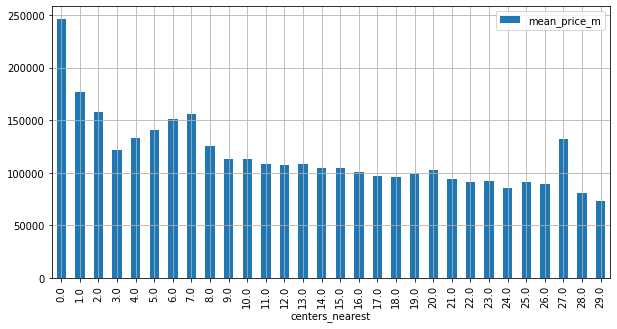

In [29]:
df_spb_m_mean = df_spb.pivot_table(index='centers_nearest', values='price_m', aggfunc=['mean'])
df_spb_m_mean.columns = ['mean_price_m']
df_spb_m_mean.plot(y = 'mean_price_m', kind='bar', figsize = (10, 5), grid=True) 


Из гафика видно, что с уменьшением растояния от 2 км. стоимость кв.метра значительно изменяется, при этом однако после 2 км идет рост цены, и только после 7 км идет уже резкое дальнейшее падение. Это позволят предположить, что  центр расположен в 7-х километровой зоне.

Выделим квартиры в центре. И расчитам коэффициенты корреляции.

In [50]:
df_spb_center = df_spb.query('centers_nearest <= 7')


In [51]:
df_spb_center[['last_price', 'total_area', 'rooms', 'ceiling_height']].corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.668248,0.342710,0.263220
total_area,0.668248,1.000000,0.730079,0.361824
rooms,0.342710,0.730079,1.000000,0.283023
ceiling_height,0.263220,0.361824,0.283023,1.000000


Значения коэффициентов корреляции (к.к.) 0.67, 0.34, 0.26 указывают на то, что цена квартиры в первую очередь зависит от площади квартиры (достаточно сильная связь (к.к.=0.67)), затем от количества комнат к.к.=0.34 - связь слабая (стоит отметить, что между количеством комнат и площадью достаточно сильная связь к.к.=0,73), затем от высоты потолков к.к.=0.26 (связь слабая).

Определим, как влияет на цену: число комнат, этаж, удалённость от центра, дата размещения объявления. 

In [52]:
df_spb_center[['last_price', 'floor', 'rooms', 'cityCenters_nearest']].corr()


,last_price,floor,rooms,cityCenters_nearest
last_price,1.000000,0.107170,0.342710,-0.045679
floor,0.107170,1.000000,-0.043979,0.236395
rooms,0.342710,-0.043979,1.000000,-0.172026
cityCenters_nearest,-0.045679,0.236395,-0.172026,1.000000


Значения коэффициентов корреляции (к.к.) 0.1, 0.34 указывают на слабое влиение этажа и количества комнат на стоимость жилья в центре.  На порядок, по сравненю с общей выборкой уменьшился к.к. между ценой и удаленностью от центра. Можно утверждать, что в данной локации цена жилья не зависит от удаленности от центра.

Интересно значительное увеличение к.к. между этажом и стоимостью (по сравнению с общей совокупностью данных). Детальней рассмотрим как зависит цена от того, на каком этаже расположена квартира, в 2-х километровой локации. 

<AxesSubplot:xlabel='floor'>

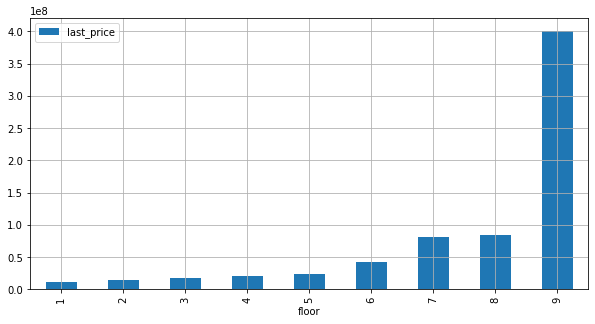

In [53]:
df_spb_center_2 = df_spb.query('centers_nearest <= 2')
df_spb_center_2.pivot_table(index=['floor'], values=['last_price']).plot(y = 'last_price', kind='bar', figsize = (10, 5), grid=True)


In [46]:

display(df_spb_center.query('floor >= 7').sort_values(by='last_price', ascending=False))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_m,share_area_living,share_area_kitchen,year,month,weekday,floor_group,centers_nearest
14706,15,401300000.0,401.0,2016-02-20,5,NaN,9.0,204.0,9,False,...,478.0,393.0,1.000748e+06,0.508728,0.059850,2016,2,5,последний,2.0
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9.0,131.0,7,NaN,...,227.0,501.0,6.600000e+05,0.540429,0.082508,2015,8,3,другой,2.0
10362,5,83820000.0,153.0,2017-09-29,3,3.20,9.0,82.0,8,NaN,...,227.0,169.0,5.478431e+05,0.535948,0.071895,2017,9,4,другой,2.0
5232,2,77612080.0,152.3,2017-09-08,2,3.53,9.0,82.0,7,False,...,478.0,341.0,5.096000e+05,0.538411,0.072226,2017,9,4,другой,2.0
581,20,65000000.0,365.0,2019-03-18,7,2.90,7.0,NaN,7,NaN,...,58.0,NaN,1.780822e+05,NaN,NaN,2019,3,0,последний,2.0
23369,19,20900000.0,129.0,2016-05-13,3,3.02,8.0,81.0,7,NaN,...,NaN,188.0,1.620155e+05,0.627907,0.147287,2016,5,4,другой,2.0


Стоит отметить что квартир расположенных выше 9 этажа нет. Единичны предложения квартир расположенных выше 7 этажа. Квартира на 9 этаже имеет стоимость в пять раз превышающую стоимость квартир на 7,8 этажах, и на первый взгляд кажется 'вбросом' который следует исключить. Однако учитывая уникальность расположения квартиры на 9 из 9 этажей её площадь, этого делать без осмотра квартиры не стоит.

Расчитаем коэффициент корреляции  и определим, зависит ли цена от даты размещения: дня недели, месяца и года.

In [54]:

df_spb_center[['last_price', 'year', 'month', 'weekday']].corr()


,last_price,year,month,weekday
last_price,1.000000,-0.053708,-0.022501,0.017974
year,-0.053708,1.000000,-0.243509,0.002113
month,-0.022501,-0.243509,1.000000,0.025111
weekday,0.017974,0.002113,0.025111,1.000000


Значения коэффициентов корреляции меньше 0,1 указывают на то, что цена квартиры не зависит от времени (года, месяца, дня недели) подачи объявления о продаже.

# Заключение <a id='5'></a>


По результатам предварительной обработки данных: 
заменили не указанное число балконов (скорее всего, их нет) на 0, заменили вещественный тип данных в столбце: balcony на целочисленный, заменили тип данных в first_day_exposition на datetime.

Выявили, что в данных присутствует достаточно большое количество пропусков, например высототы потолка, удалённости от центра и др. Однако учитывая многообразие параметров, характеризующих квартиру (и в той или иний мере влияющих на цену квартиры), и с целью недопущения внесения искажений в результаты анализа  влияния исследуемых параметров на цену квартиры, не заменяли отсутствующие значения средними или медианными значениями.


По результатам анализа вывили, что:
- наибольшее количество предложений приходится на квартиры с площадью от 30 до 60 кв.м, единичны предложения квартир с площадью более 400 кв.м. Явно выделяется квартира площадью около 900 кв.м. 

- при этом больше всего кваритр с ценой от 2 до 6 млн.р., единичны предложения квартир ценой выше 18 млн.р. Явно выделяется квартира с ценой около 75 млн.р. 

- на продажу выставлены преимущественно 2-3 комнатные кваритры. Единичны предложения квартир с числом комнат больше 10. 

- наибольшее количество предложений приходится на квартиры с высотой потолков от 2.5 до 2.8 м., при этом непонятна высота потолков больше 10-15 м (высота 4-5 этажного дома!), а также большое к-во квартир (16 шт.) с высотой 26-28 м (предположили, что при вводе данных не поставили запятую), устранили эту анамалию. Явно выделяется квартира высотой 100 м, а также непонятны квартиры с высотой менее 2 м. 

- детальное рассмотрение выявленных анамалий не позволило предложить хорошую замену квартирам:
    • с высотой потолков менее 2 м,
    • с высотой потолков более 6 м (до 6 м можно предположить, что это двухуровневые квартиры),
    • (явно отдельно стоящему значению) с ценой 760млн.р.,
    • с площадью 900кв.м.,
    • с числом комнат 19. 
    • Эти квартиры исключили из анализа.

- среднее время продажи квартиры составляет 181 день, медианное значение времени продажи почти в два раза меньше и составляет 95 дней (т.е. половина продаж совершается в теченние 3 месяцев). Быстрыми можно считать продажи не превышающие 45 дней, длительными - более 232 дней. 

- При анализе общей совокупности данных, расчитаны значения коэффициентов корреляции (к.к.) 0.7, 0.39, -0.26 указывающие на то, что цена квартиры в первую очередь зависит от площади квартиры (достаточно сильная связь (к.к.=0.7)), затем от количества комнат к.к.=0.39 - связь слабая (стоит отметить, что между количеством комнат и площадью достаточно сильная связь к.к.=0,76), затем от растояния до центра к.к.=-0.26 (связь слабая), при этом знак минус указыват на то, что чем дальше от центра тем стоимость меньше, к.к.=0.02 указывает отсутствие взаимосвязи между ценой и этажом. По данным сводных таблиц сделали вывод, что на первом этаже стоимость квартир ниже, а на последнем этаже выше. 

Выделии 10 населенных пунктов с наибольшим количеством предложений. Определили, что из них максимальная стоимость кв. метра в Санкт-Петербурге, минимальная в Выборге.

Анализ квартир в ценре Санкт-Петербурга:
- Выявили, что центр Санкт-Петербурга расположен в 2-х километровой зоне. При этом значения коэффициентов корреляции (к.к.) 0.67, 0.34, 0.26 показали, что в центре СПб цена квартиры сильно зависит от площади квартиры (достаточно сильная связь (к.к.=0.67)), от количества комнат к.к.=0.34 - слабо (стоит отметить, что между количеством комнат и площадью достаточно сильная связь к.к.=0,73),  от высоты потолков также слабо к.к.=0.26 (связь слабая). 
- Коэффициентов корреляции (к.к.) 0.1, 0.34 указывают на слабое влиение этажа и количества комнат на стоимость жилья в центре. 
- Стоит отметить, что на порядок, по сравнению с общей выборкой уменьшился к.к. между ценой и удаленностью от центра. Можно утверждать, что в данной локации цена жилья не зависит от удаленности от центра. 

Выявили также, что цена квартиры во всех исследуемых категориях не зависит от времени (года, месяца, дня недели) подачи объявления о продаже (к.к. меньше 0,1). 
